<h3 style="text-align: center;"><b>Generative Adversarial Networks</b></h3>


Цель исследования: обучить GAN генерировать лица людей и оценить качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set(style='darkgrid', font_scale=1.2)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Подготовка данных

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Напишем функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому возьмём размер 128)

---

Обучение производилось на платформе Kaggle.

In [2]:
PATH=r'/kaggle/input/faces-dataset-small'


train_ds = ImageFolder(PATH,transform=tt.Compose([
        tt.ToTensor(),
        ]),)
train_dl = DataLoader(train_ds, 10, shuffle=True)

In [3]:
def show_img(img):
    img=img.permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')

def show_img_sample(img,size=5):
    img=make_grid((img.detach()[:size*size]), nrow=size)
    show_img(img)

Посмотрим на исходное изображение:

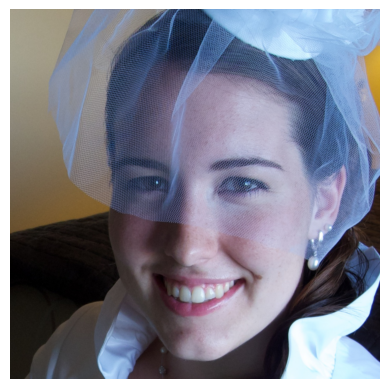

In [4]:
img=next(iter(train_dl))
show_img(img[0][0])

In [5]:
STATS=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def denorm(img_tensors):
    return img_tensors * STATS[1][0] + STATS[0][0]

Сделаем DataLoader:

In [6]:
def get_dataloader(image_size, batch_size, data_path):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    train_ds = ImageFolder(data_path, transform=tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*STATS)]))
    
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True,drop_last=True)
    return train_dl

In [7]:
def show_img_sample(img,size=5):
    img=denorm(img)
    img=make_grid((img.detach()[:size*size]), nrow=size)
    show_img(img)

In [8]:
IMAGE_SIZE=128
BATCH_SIZE=32
train_dl=get_dataloader(IMAGE_SIZE, BATCH_SIZE, PATH)

Посмоотрим на уменьшенные изображения:

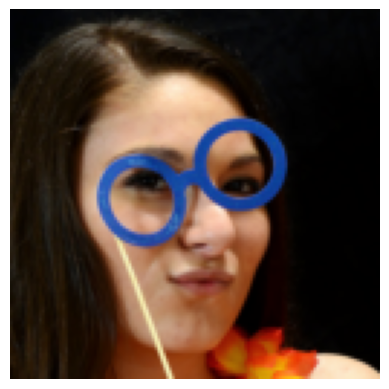

In [9]:
img=next(iter(train_dl))[0]
show_img_sample(img,1)

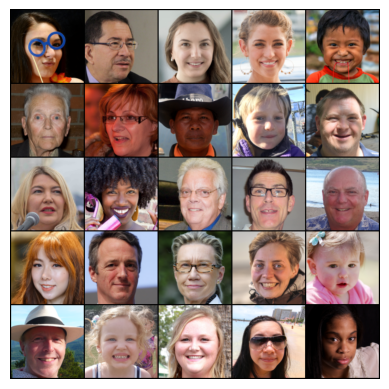

In [10]:
show_img_sample(img)

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Сделанный выше Dataloader при загрузке каждого батча меняет размер изображений, и повторяет эту операцию постоянно на каждой эпохе. Из-за этого время расчёта одной эпохи составляет около 2.30 минут. Т.к. у нас ечть свободное место на диске мы можем предварительно подготовить наши изображения сохранив уменьшенные изображения и создать даталоадер для этих изображений. Таким образом время расчёта одной эпохи уменьшится до 11 секунд:

In [135]:
def save_croped_images(image_size, data_path, saving_path):
    ds = ImageFolder(data_path, transform=tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        ]))

    if not os.path.exists(saving_path):
        os.mkdir(saving_path)

    if not os.path.exists(saving_path+'/crop_img'):
        os.mkdir(saving_path+'/crop_img')
    else:
        return

    for i, img in enumerate(ds):
        save_image(img[0], saving_path+f'/crop_img/{i}.png')


def get_dataloader_crop(batch_size, data_path):
    train_ds = ImageFolder(data_path, transform=tt.Compose([
        tt.ToTensor(),
        tt.Normalize(*STATS)]))

    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return train_dl


PATH_TO_CROPED_IMG = '/kaggle/input/fliker-faces-crop-small'
save_croped_images(IMAGE_SIZE, PATH, PATH_TO_CROPED_IMG)

BATCH_SIZE = 32
train_dl = get_dataloader_crop(BATCH_SIZE, PATH_TO_CROPED_IMG)


In [137]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_dl = DeviceDataLoader(train_dl, DEVICE)

## Построение и обучение модели

Сконструируем генератор и дискриминатор. Дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1). Генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`.

In [113]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 64 x 64

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding='same', bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding='same', bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding='same', bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Flatten(),
    nn.Linear(512*4*4, 512*4, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(512*4, 512, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(512, 1, bias=False),
    nn.Sigmoid())


In [114]:
latent_size = 128  # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.Flatten(),
    nn.Linear(latent_size, 512, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(512, 1024, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Linear(1024, 2048, bias=False),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Unflatten(1, (2048, 1, 1)),

    nn.ConvTranspose2d(2048, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 512, kernel_size=5, padding='same', bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 512, kernel_size=5, padding='same', bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding='same', bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 256, kernel_size=3, padding='same', bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding='same', bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 128, kernel_size=3, padding='same', bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding='same', bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, padding='same', bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(32, 32, kernel_size=3, padding='same', bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(32, 32, kernel_size=3, padding='same', bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),

    # out: 32 x 64 x 64

    nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(32, 32, kernel_size=3, padding='same', bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(32, 3, kernel_size=3, padding='same', bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)


Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [16]:
def get_memory():
    '''
    for CUDA memory check
    '''
    print('CUDA memory used:', torch.cuda.torch.cuda.memory_allocated()/1024/1024/1024)


In [17]:
from IPython import display


class TrainerPlotter():
    '''
    Выводит графики и изображения во время тренировки
    '''

    def __init__(self) -> None:
        self.col = 4
        self.row = 4
        shape = (self.col, self.row)
        self.figure = plt.figure(figsize=(12, 12))

        self.displ = display.display(self.figure, display_id=True)

        self.ax_real_img = []
        self.ax_pred_img = []

        for i in range(self.row):
            self.ax_real_img.append(plt.subplot2grid(shape=shape, loc=(i, 0), colspan=1))
            self.ax_pred_img.append(plt.subplot2grid(shape=shape, loc=(i, 1), colspan=1))

        self.ax_loss_graph = plt.subplot2grid(shape=shape, loc=(0, 2), rowspan=2, colspan=2)
        self.ax_score_graph = plt.subplot2grid(shape=shape, loc=(2, 2), rowspan=2, colspan=2)

    def plot_image_and_graph(self, X_batch, reconstructed, loss, score):
        for k in range(self.row):
            sample_img = np.rollaxis(X_batch[k].numpy(), 0, 3)
            reconstructed_img = np.rollaxis(reconstructed[k].numpy(), 0, 3)

            self.plot_image(self.ax_real_img[k], sample_img, title='Real')
            self.plot_image(self.ax_pred_img[k], reconstructed_img,
                            title='Fake', title_color='red')

        self.plot_graph(self.ax_loss_graph, loss, title='Loss', labels=[
                        'Generator', 'Discriminator'], ax_labels=False)
        self.plot_graph(self.ax_score_graph, score, title='Score', labels=['Real', 'Fake'])

        self.displ.update(self.figure)

    def plot_image(self, ax, data, title, title_color='blue'):
        ax.clear()
        ax.imshow(data)
        ax.set_title(title, color=title_color)
        ax.axis('off')

    def plot_graph(self, ax, data, title, labels, ax_labels=True):
        ax.clear()
        y = np.column_stack(data)
        x = range(1, len(y)+1)
        ax.plot(x, y, label=labels)
        if ax_labels:
            ax.set_xlabel('epoch')
            ax.grid(True, axis='x')
        else:
            ax.set_xticklabels('')
        ax.legend()
        ax.set_title(title)

    def end(self):
        plt.close()


Для обучения напишем класс ModelTrainer который будет обучать модель, сохранять историю и выводить графикии иизображения на каждой эпохе:

In [18]:
import pickle


class ModelTrainer():
    '''
    Train model
    '''

    def __init__(self) -> None:
        self.losses_g = []
        self.losses_d = []
        self.real_scores = []
        self.fake_scores = []

        self.max_epoch = 0
        self.current_epoch = 0
        self.plotter = TrainerPlotter()
        self.data_to_plot = None
        self.gen_img = None

        get_memory()

    def eval_epoch(train_fn, *args, **kwargs):
        def wrapper(self, *args, **kwargs):
            self.loss_d_per_epoch = []
            self.loss_g_per_epoch = []
            self.real_score_per_epoch = []
            self.fake_score_per_epoch = []

            train_fn(self, *args, **kwargs)

            self.losses_g.append(np.mean(self.loss_g_per_epoch))
            self.losses_d.append(np.mean(self.loss_d_per_epoch))
            self.real_scores.append(np.mean(self.real_score_per_epoch))
            self.fake_scores.append(np.mean(self.fake_score_per_epoch))
        return wrapper

    def train(self, model, opt, scheduler, loss_fn, score_fn,  epochs, train_loader, silent=False):
        self.set_params(model, loss_fn, score_fn, epochs)
        for _ in tqdm(range(epochs)):
            self.train_epoch(opt, scheduler, train_loader)
            self.save_gen_image()
            self.draw_graphs_and_img()
            self.current_epoch += 1
            if self.current_epoch % 100 == 0:
                self.save_model()
        self.plotter.end()

    def set_params(self, model, loss_fn, score_fn, epochs):
        self.max_epoch += epochs
        self.model = model
        self.loss_fn = loss_fn
        self.score_fn = score_fn

    @eval_epoch
    def train_epoch(self, optimizer, scheduler, train_loader):
        for real_images, _ in train_loader:
            self.train_discriminator(optimizer, real_images)
            self.train_generator(optimizer)
        self.data_to_plot = real_images.detach().cpu()
        scheduler["generator"].step()
        scheduler["discriminator"].step()

    def train_discriminator(self, optimizer, real_images):
        optimizer["discriminator"].zero_grad()

        real_targets = 1 - torch.rand(real_images.size(0), 1, device=DEVICE).uniform_(0, 0.15)
        cur_real_score, real_loss = self.classify_image(
            real_images, real_targets)

        fake_images = self.generate_fake_img()
        fake_targets = torch.rand(fake_images.size(0), 1, device=DEVICE).uniform_(0, 0.15)
        cur_fake_score, fake_loss = self.classify_image(
            fake_images, fake_targets)

        self.real_score_per_epoch.append(cur_real_score)
        self.fake_score_per_epoch.append(cur_fake_score)

        loss_d = real_loss + fake_loss
        loss_d.backward()
        optimizer["discriminator"].step()

        self.loss_d_per_epoch.append(loss_d.item())

    def train_generator(self, optimizer):
        optimizer["generator"].zero_grad()

        fake_images = self.generate_fake_img()

        preds = self.model["discriminator"](fake_images)
        targets = torch.ones(BATCH_SIZE, 1, device=DEVICE)
        loss_g = self.loss_fn["generator"](preds, targets)

        loss_g.backward()
        optimizer["generator"].step()

        self.loss_g_per_epoch.append(loss_g.item())

    def classify_image(self, img, label):
        preds = self.model["discriminator"](img)
        loss = self.loss_fn["discriminator"](preds, label)
        score = torch.mean(preds).item()
        return score, loss

    def generate_fake_img(self):
        latent = torch.randn(BATCH_SIZE, latent_size, 1, 1, device=DEVICE)
        fake_images = self.model["generator"](latent)
        return fake_images

    def save_gen_image(self):
        self.gen_img = self.generate_fake_img().detach().cpu()
        self.gen_img = denorm(self.gen_img)

    def draw_graphs_and_img(self):
        losses = (self.losses_g, self.losses_d)
        scores = (self.real_scores, self.fake_scores)
        self.data_to_plot = denorm(self.data_to_plot)
        self.plotter.plot_image_and_graph(
            self.data_to_plot[:4], self.gen_img, losses, scores)

    def print_info(self):
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            self.current_epoch, self.max_epoch,
            self.losses_g[-1], self.losses_d[-1], self.real_scores[-1], self.fake_scores[-1]))

    def save_model(self):
        torch.save(self.model['discriminator'].state_dict(),
                   f'discriminator_{self.current_epoch}.pt')
        torch.save(self.model['generator'].state_dict(), f'generator_{self.current_epoch}.pt')
        data_mt = {'losses_g': self.losses_g,
                   'losses_d': self.losses_d,
                   'real_scores': self.real_scores,
                   'fake_scores': self.fake_scores,
                   'current_epoch': self.current_epoch,
                   }
        with open(f'data_mt_{self.current_epoch}.pickle', 'wb') as file:
            pickle.dump(data_mt, file)

    def load_model_trainer(self, path):
        with open(path, 'rb') as file:
            mt_hist = pickle.load(file)
        self.losses_g = mt_hist['losses_g']
        self.losses_d = mt_hist['losses_d']
        self.real_scores = mt_hist['real_scores']
        self.fake_scores = mt_hist['fake_scores']
        self.current_epoch = mt_hist['current_epoch']
        self.max_epoch = mt_hist['current_epoch']
        self.save_gen_image()
        self.draw_graphs_and_img()


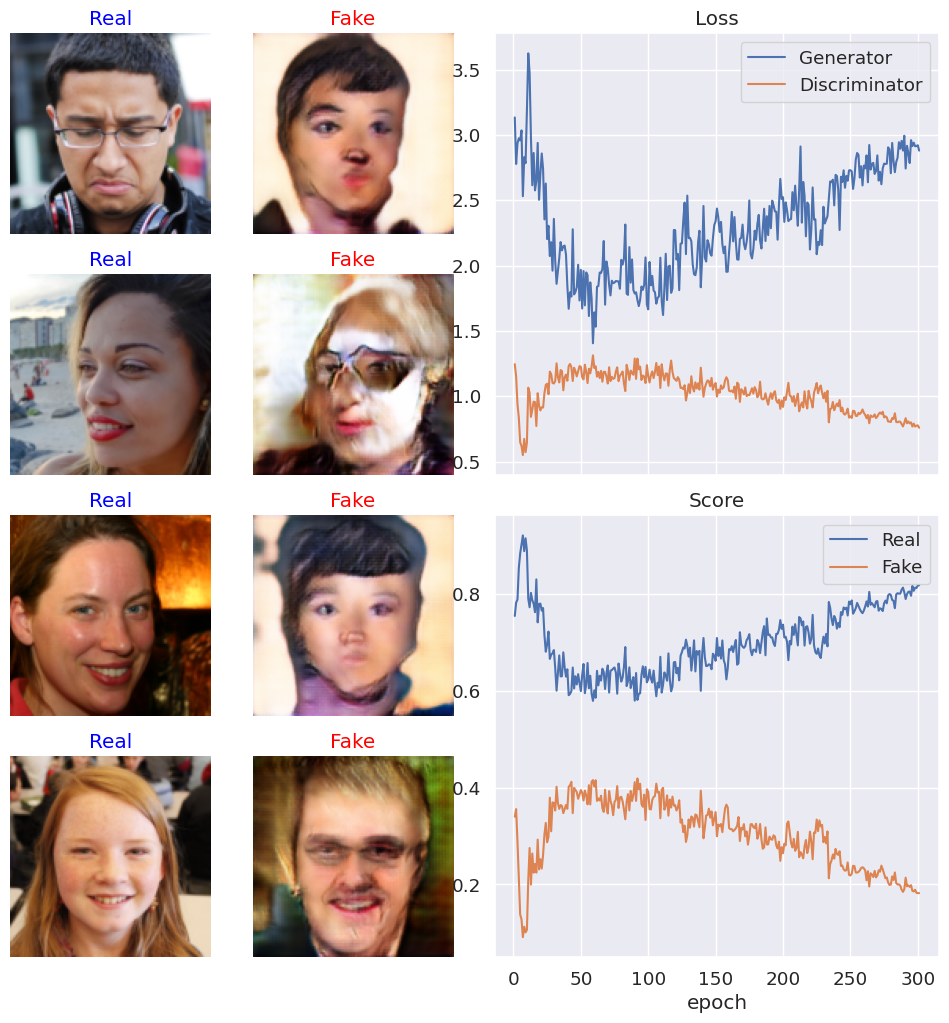

CUDA memory used: 1.8570265769958496


  0%|          | 0/50 [00:00<?, ?it/s]

In [115]:
generator = to_device(generator, DEVICE)
discriminator = to_device(discriminator, DEVICE)

lr = 0.0002

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizer = {
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(model["generator"].parameters(),
                                  lr=lr, betas=(0.5, 0.999))
}

exp_lr_scheduler = {                # as it turned out during the reserch, it's better not to change the step
    "discriminator": torch.optim.lr_scheduler.StepLR(optimizer["discriminator"], 
                                                     step_size=15, gamma=1),
    "generator": torch.optim.lr_scheduler.StepLR(optimizer["generator"],
                                                 step_size=15, gamma=1)
}

model_trainer = ModelTrainer()
model_trainer.train(model, optimizer, exp_lr_scheduler, criterion, None, 300, train_dl)


Сохраним модель и историю скоров и лоссов для возможности дообучения:

In [206]:
model_trainer.save_model()

Судя по построенным выше графикам, дискриминатор побеждает генератор. Графики скора и лосса держатся на одном и том же уровне постепенно уменьшая скор генратора и увеличивая скор дискриминатора.

## Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

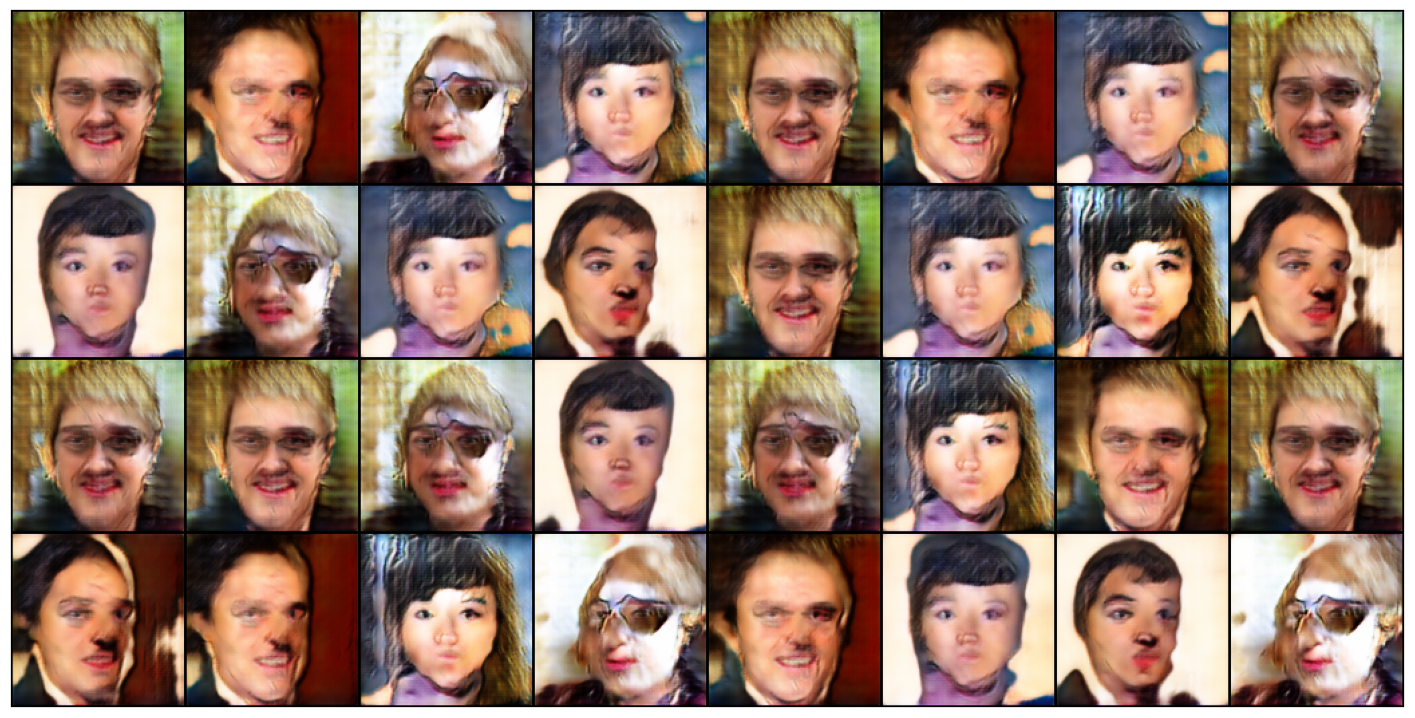

In [202]:
def show_images(generated):
    fake_images = denorm(model_trainer.generate_fake_img())
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))


show_images(None)


Качество сгенерированных картинок не самое лучшее. В ходе обучения модель начинала хорошо выделять признаки лиц, но при дальнейшем обучении качества не прибавлялось, узнаваемые очертания лиц были искревлены и размыты. Иногда на некоторых эпохах случайно попадались вполне неплохие генерации. Для улучшения качества требуются большие вычислительные мощности и большее количество данных.

## Оценка качества модели

### 4.1. Подсчет accuracy

ДЛя токо что бы не оценивать качество сгенерированных картинок глазами реализуем leave-one-out оценку. Для этого обучим 1NN Classifier пердскажим класс на всех обьектах кроме одно и проверим качество на оставшемся объекте.

Обучать 1NN достаточно долго поэтому мы посмотрим точность на 5 батчах:

In [203]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut


def get_img_and_labels(batches_amount=0):
    '''
    Returns list with generated img and img from `batches_amount` bathces
    '''
    real_img = []
    fake_img = []
    for i, data in enumerate(train_dl):
        real_img.append(data[0])
        fake_img.append(model_trainer.generate_fake_img())
        if batches_amount and batches_amount <= i+1:
            break

    real_img = torch.cat(real_img)
    fake_img = torch.cat(fake_img)

    img = torch.cat([real_img, fake_img]).detach().cpu()
    labels = np.hstack((np.ones(real_img.shape[0]), np.zeros(fake_img.shape[0])))
    return img, labels


def get_score(images, labels):
    '''
    Calculate 1NN score for images
    '''
    acc_score = []
    images = nn.Flatten()(images)
    knn = KNeighborsClassifier()
    loo = LeaveOneOut()
    for i, j in loo.split(images, labels):
        knn.fit(images[i], labels[i])
        pred = knn.predict(images[j])
        acc_score.append(pred == labels[j])
    return np.mean(acc_score)


img, labels = get_img_and_labels(batches_amount=5)
get_score(img, labels)


0.78125

Чем ниже этот показательтем тем лучше. Это означет что наши данные неразделимы и сгенерированные изображения находятся вперемешку с реальными.

### Визуализация распределений

Посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуемся методом понижения размерности  TSNE и изобразим на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Графики для всех 3 тыс изображений строятся долго и не очень информативны, поэтому можно указать количество батчей для которых мы хоти построить графики. Построим графики для 5 батчей:

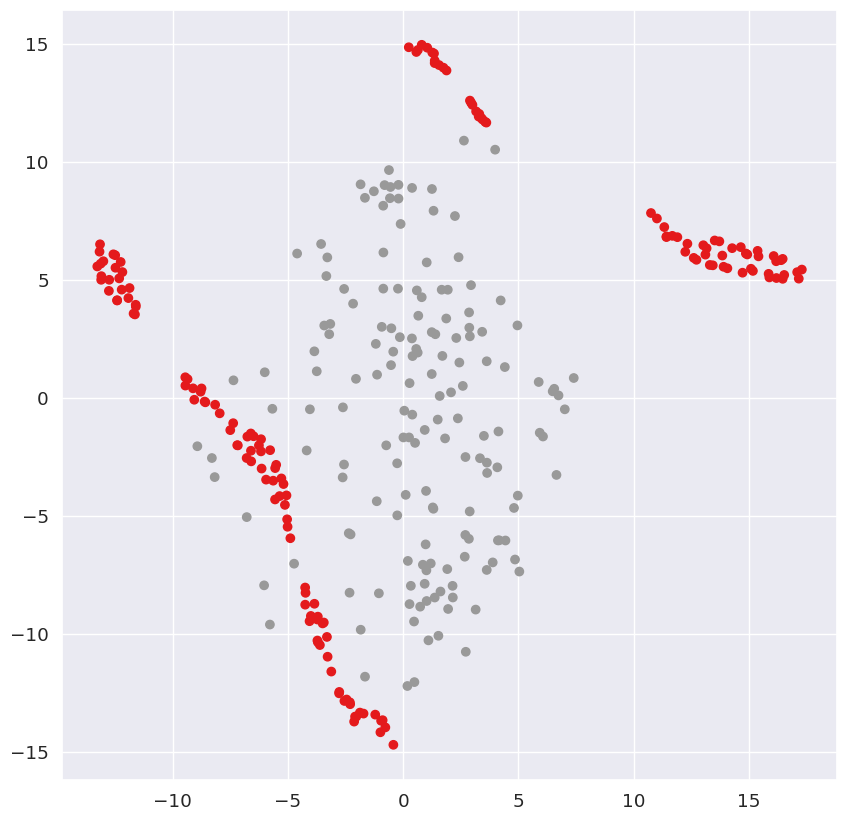

In [205]:
from sklearn.manifold import TSNE


def get_TSNE_graph(img, labels):
    img_TSNE = TSNE().fit_transform(img.view(img.shape[0], -1))

    plt.figure(figsize=(10, 10))
    plt.scatter(*img_TSNE.T, c=labels, cmap='Set1')


img, labels = get_img_and_labels(batches_amount=5)
get_TSNE_graph(img, labels)


По графикам достаточно хорошо выидно разделение между сгенерированными картинками и реальными. В одной определённой части они немного пресекают друг друга, это те лица которые получились лучше всего.